In [14]:
#I developed my code for the Multi-Line Fitting Algorithm on Google Colab. Follow the steps below to use the program.
# 1. Upload this CSCE411_Project1.ipynb file to Google Colab (Or another software compatible with .ipynb files)
# 2. Place the pickled input dictionary file in the same directory as this python file
# 3. Set the filepath variable below equal to the name of the pickled input dictionary file
file_path = 'examples_of_small_instances' #Change examples_of_instances to the name of your input file
# 4. Run the code blocks in order. The final code block will print the solution, output the solution dictionary to a pickled file, and print the scatter plots with the fitted lines.
#    If efficiency is valued over being able to view the data, the extra section at the bottom of the code for visualizing the data can be commented out

import pickle
import matplotlib.pyplot as plt
import numpy as np
data = pickle.load(open(file_path, 'rb'))

In [15]:
#Helper Functions
def calculate_error(a, b, start, end, xSum, ySum, xSquaredSum, ySquaredSum, xySum): #O(1)
    n = end - start + 1
    xSumSeg = xSum[end+1] - xSum[start]                      #Gives the x sum between starting and ending points using the sum list generated by my prefix sums function, O(1)
    ySumSeg = ySum[end+1] - ySum[start]                      #y sum,   O(1)
    xSquaredSumSeg = xSquaredSum[end+1] - xSquaredSum[start] #x^2 sum, O(1)
    xySumSeg = xySum[end+1] - xySum[start]                   #x*y sum, O(1)
    ySquaredSumSeg = ySquaredSum[end+1] - ySquaredSum[start] #y^2 sum, O(1)

    error = ySquaredSumSeg - 2*a*xySumSeg - 2*b*ySumSeg + a**2 * xSquaredSumSeg + 2*a*b*xSumSeg + b**2 * n #distributed out (yi − axi − b)^2 with the sums distributed to calculate the error in constant time
    return error

#Used so we don't continually calculate the same sums repeatedly
#Allows us to turn the caluclations for a, b, and error from O(n) to O(1)
#To get the sum between points for the current instance, subtract sumList[start] from sumList[end+1]
def prefixSums(values): #O(n), dynamic programming approach, solves sums per instance as small subproblems to reuse for main problems of calculating a, b, and error (avoid repetition and redundancy)
    sumList = [0]                              #Initializes list of sums
    for value in values:
        sumList.append(sumList[-1] + value)    #The sum at index i is equal to the value in the list at i + the sum of the values beforehand
    return sumList                             #Returns a list of the sums of the values in the input list at the specified index

def calculate_a_b(start, end, xSum, ySum, xSquaredSum, xySum): #O(1)
    n = end - start + 1                                                    #number of points
    xSumSeg = xSum[end+1] - xSum[start]                                    #same as in calculate_error function
    ySumSeg = ySum[end+1] - ySum[start]
    xSquaredSumSeg = xSquaredSum[end+1] - xSquaredSum[start]
    xySumSeg = xySum[end+1] - xySum[start]
    if (n * xSquaredSumSeg - xSumSeg ** 2) == 0:                               #was getting warnings before adding this check, prevents divide by zero errors
      return 0,0
    a = (n * xySumSeg - xSumSeg * ySumSeg)/(n * xSquaredSumSeg - xSumSeg**2)   #given in project instructions
    b = (ySumSeg - a * xSumSeg)/n
    return a, b


In [16]:
#Implementing the Multi-Line Fitting Algorithm, O(n^2)
def multiLineFitting(data):
  n_vals = data["n_list"] #points in each instance
  x_vals = data["x_list"] #x coordinates
  y_vals = data["y_list"] #y coordinates
  C_vals = data["C_list"] #additional error each time we create a new line per instance

  k_list = []             #number of lines used in optimal solution
  last_points_list = []   #ending point for each line per instance
  OPT_list = []           #Optimal cost per instance

  for instance in range(len(n_vals)): #iterate over each instance

    #generating sum lists for the current instance
    xSum = prefixSums(x_vals[instance])                                                # O(n)
    ySum = prefixSums(y_vals[instance])                                                # O(n)
    xSquaredSum = prefixSums([x**2 for x in x_vals[instance]])                         # O(n)
    ySquaredSum = prefixSums([y**2 for y in y_vals[instance]])                         # O(n)
    xySum = prefixSums([x*y for x, y in zip(x_vals[instance], y_vals[instance])])      # O(n)

    errors = [[0 for _ in range(n_vals[instance])] for _ in range(n_vals[instance])]   #table to store all the errors for the potential line segments in the current instance
    for i in range(n_vals[instance]):
        for j in range(i, n_vals[instance]):                                           #O(n^2)
            a, b = calculate_a_b(i, j, xSum, ySum, xSquaredSum, xySum)
            errors[i][j] = calculate_error(a, b, i, j, xSum, ySum, xSquaredSum, ySquaredSum, xySum)

    currentMinCost = [0] + [float('inf')] * n_vals[instance]  #Cost for first point is 0, setting rest to infinity in case min cost ends up being high, code won't ever choose initialized value over actual min cost
    partitions = [-1] * n_vals[instance]                      #Used to find the optimal starting point fo a line segment given its end point

    for i in range(1, n_vals[instance] + 1):
        for j in range(i):
            cost = currentMinCost[j] + errors[j][i - 1] + C_vals[instance] #cost calculation is sum of minimum cost of previous points, error stored in the error matrix, and cost to create a new line
            if cost < currentMinCost[i]:
                currentMinCost[i] = cost
                partitions[i - 1] = j

    OPT_list.append(currentMinCost[-1]) #add optimal cost for this instance to key pair

    #getting the ending point of each line
    lastPoints = []
    k = 0
    i = n_vals[instance] - 1
    while i >= 0:
        lastPoints.append(i)
        i = partitions[i] - 1
        k += 1

    lastPoints.reverse() #reverse list to correct segment order
    last_points_list.append(lastPoints) #add the end points of the segments for this instance to key pair
    k_list.append(k) #add number of lines used for this instance to key pair

################################## Extra section for displaying graphs with fitted lines

    plt.figure(instance)
            #scatter plotss
    plt.scatter(x_vals[instance], y_vals[instance], color='blue') #placing the input points per instance

    lastPoint = 0
    for point in last_points_list[instance]:
        xRange = np.linspace(x_vals[instance][lastPoint], x_vals[instance][point], 100)
        a, b = calculate_a_b(lastPoint, point, xSum, ySum, xSquaredSum, xySum) #creating the lines from the
        plt.plot(xRange, a*xRange + b, color='red') #placing fitted line
        lastPoint = point+1
    #labeling the graphs
    plt.title(f"Instance {instance+1}")
    plt.xlabel('x')
    plt.ylabel('y')

##################################

  solution = {'k_list': k_list, 'last_points_list': last_points_list, 'OPT_list': OPT_list} #returns the solution dictionary

  with open('Solution', 'wb') as file: #writing the solution dictionary to a pickled file
    pickle.dump(solution, file)

  return solution


Solution dictionary printed below and outputted to file named 'Solution' in current working directory.


<ipython-input-16-eb0e726c917e>:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(instance)


{'k_list': [20, 24, 24, 20, 19, 20, 24, 19, 20, 17, 21, 24, 23, 20, 20, 19, 18, 22, 24, 17, 21, 21, 21, 21, 21, 22, 22, 21, 21, 20, 21, 20, 20, 21, 17, 21, 21, 20, 20, 19, 19, 19, 20, 20, 20, 19, 20, 19, 20, 20, 12, 10, 12, 10, 7, 9, 10, 13, 8, 11, 12, 12, 12, 7, 12, 11, 13, 10, 13, 10, 10, 10, 10, 15, 11, 11, 10, 10, 12, 10, 10, 11, 13, 11, 13, 9, 10, 8, 11, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10], 'last_points_list': [[30, 46, 69, 92, 121, 137, 155, 177, 203, 226, 246, 256, 261, 270, 287, 297, 316, 338, 351, 361], [30, 33, 95, 135, 143, 166, 185, 213, 231, 246, 267, 284, 306, 317, 321, 330, 332, 351, 359, 375, 388, 397, 399, 404], [10, 16, 25, 83, 125, 147, 150, 156, 181, 195, 208, 222, 227, 238, 262, 276, 283, 295, 301, 306, 327, 339, 374, 389], [9, 54, 71, 99, 111, 118, 126, 141, 157, 173, 189, 211, 231, 256, 283, 301, 319, 336, 366, 387], [38, 48, 64, 104, 151, 168, 177, 184, 198, 208, 223, 240, 265, 282, 294, 303, 311, 328, 352], [52, 92, 114, 129, 133, 177, 185, 199, 225, 246

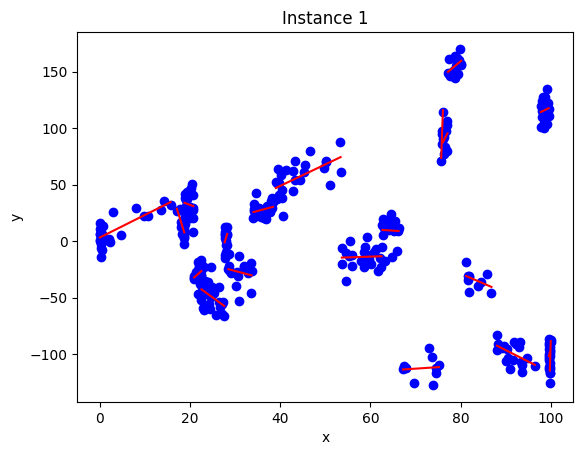

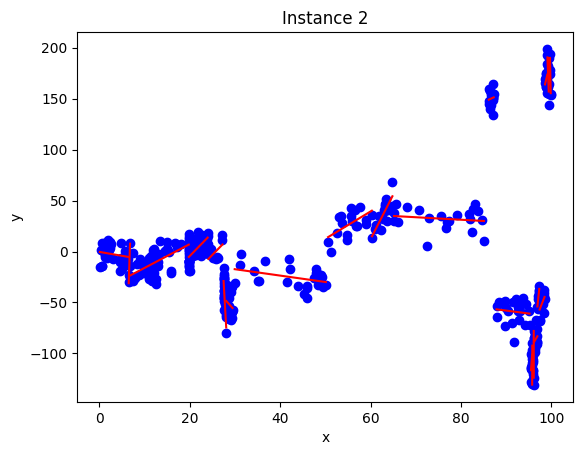

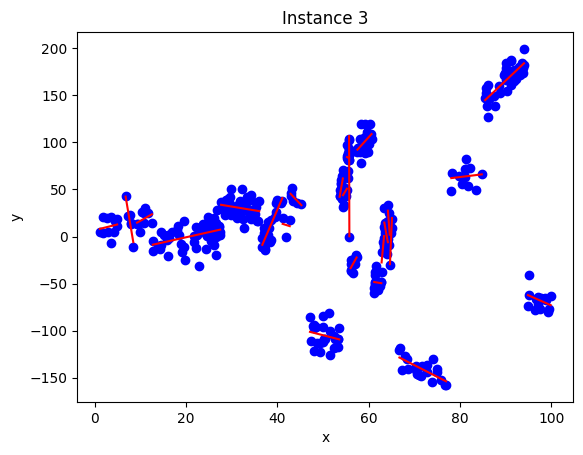

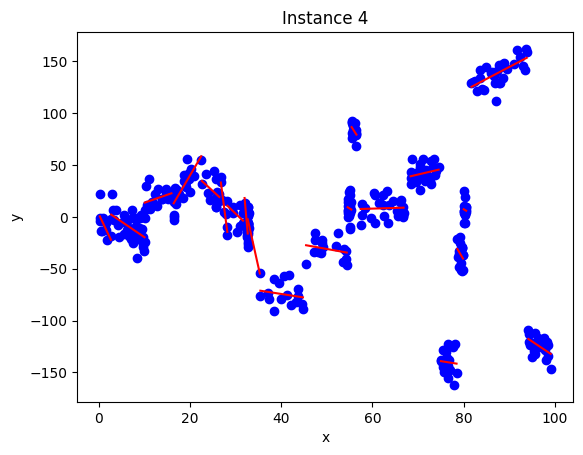

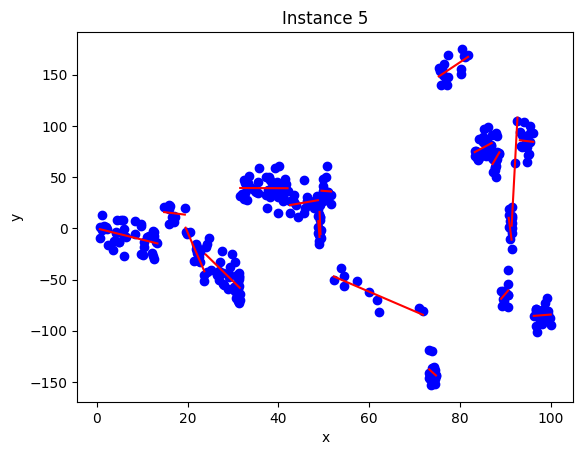

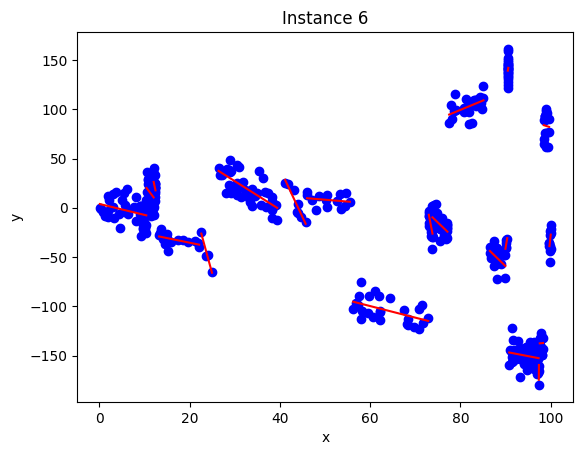

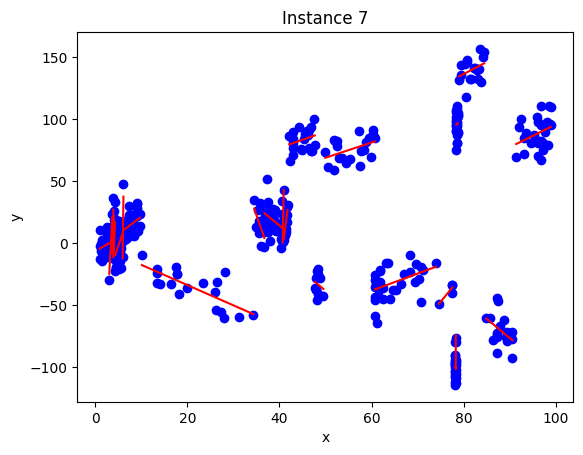

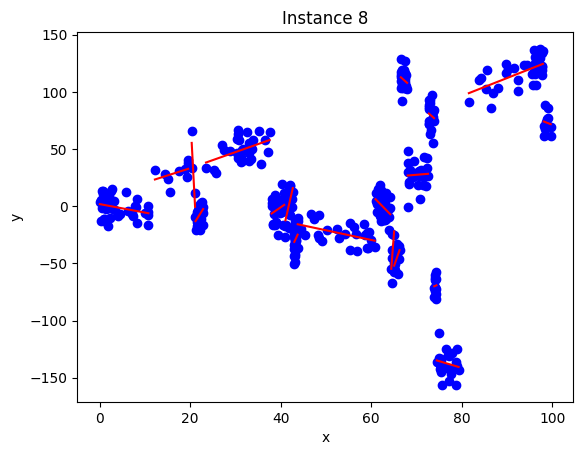

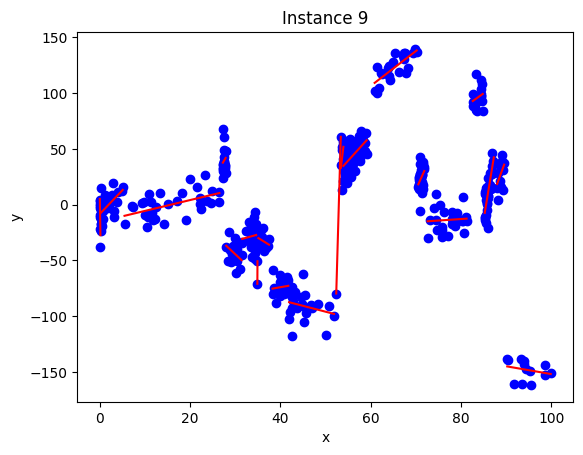

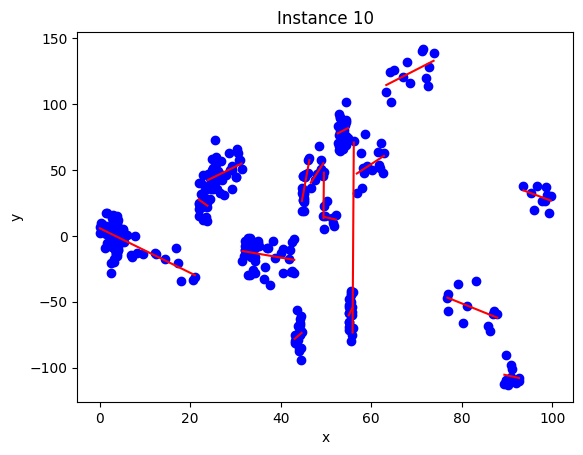

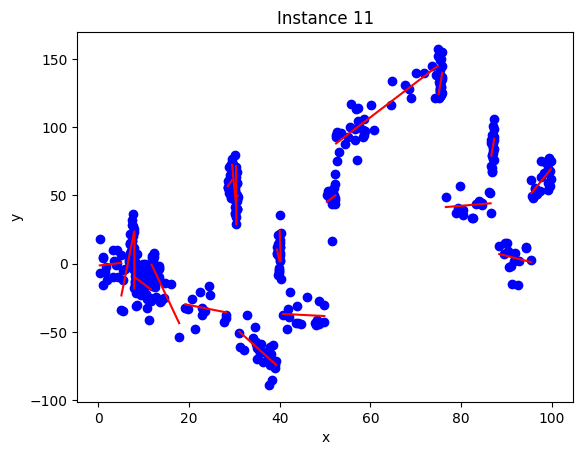

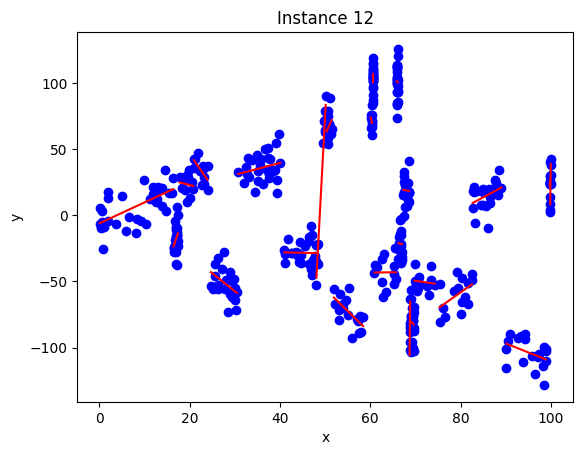

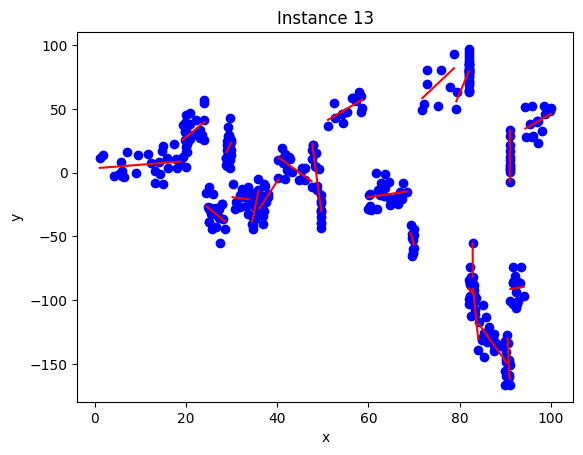

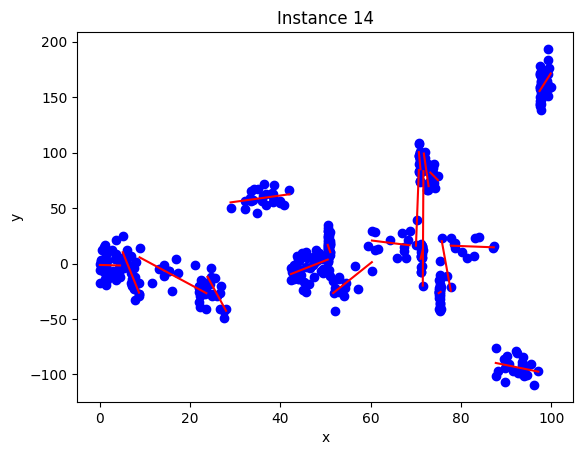

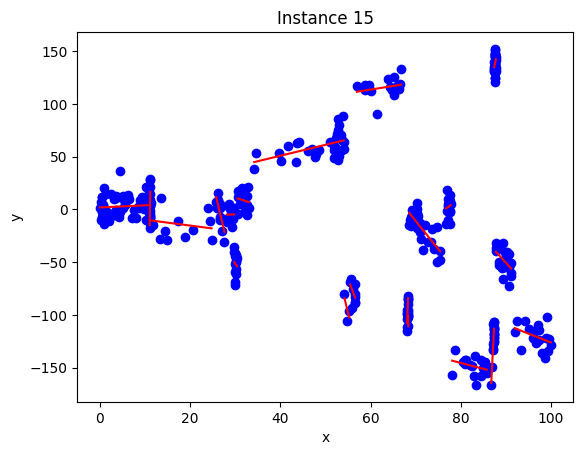

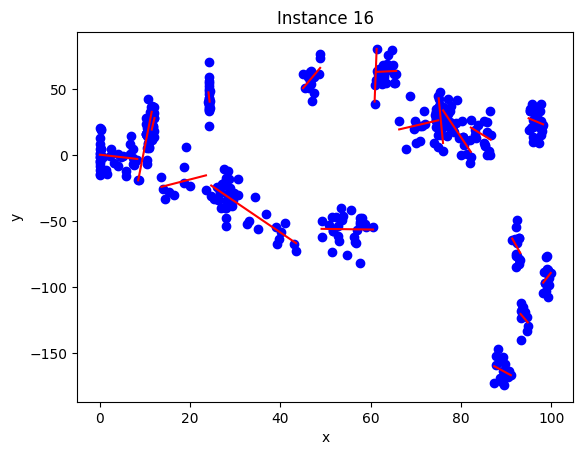

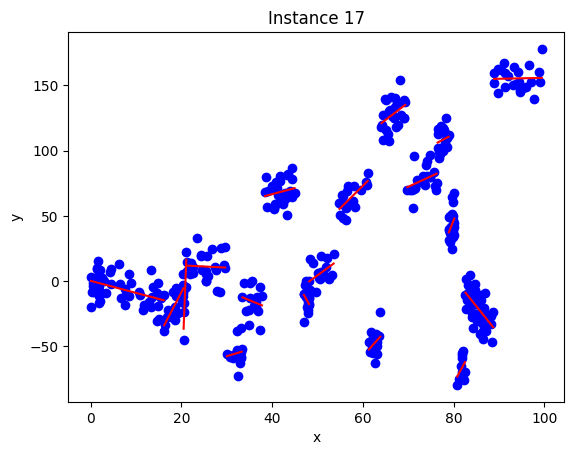

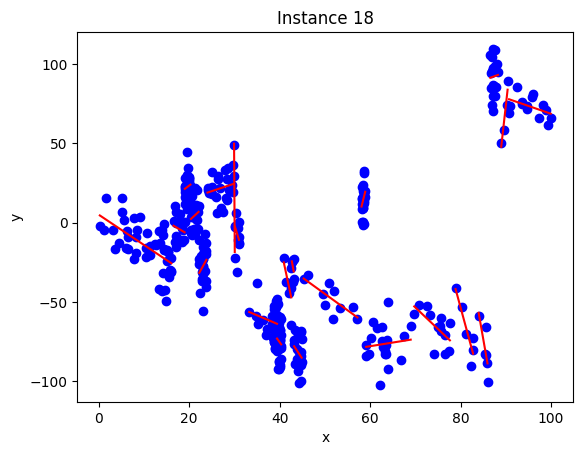

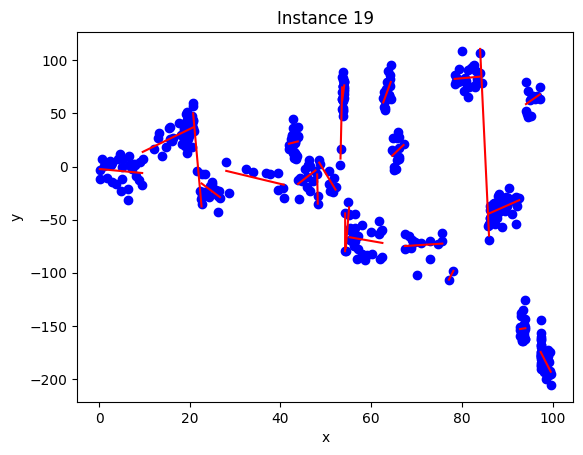

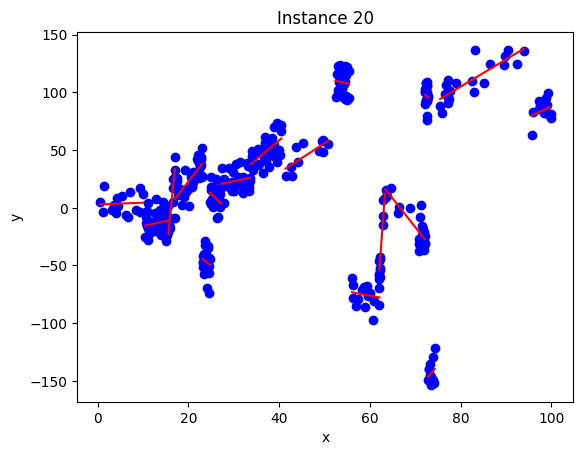

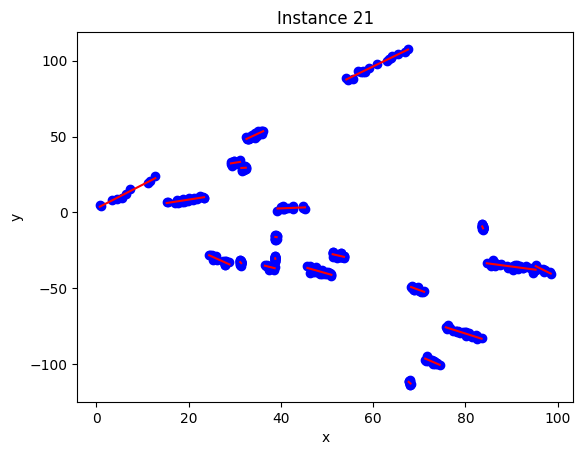

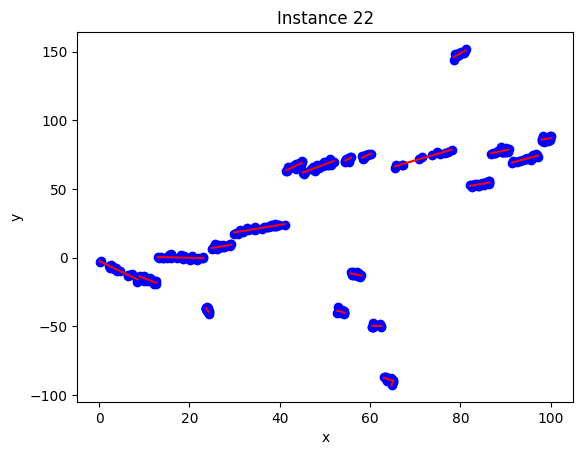

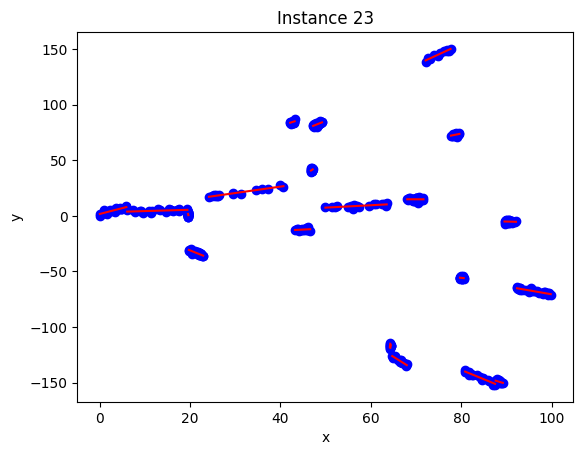

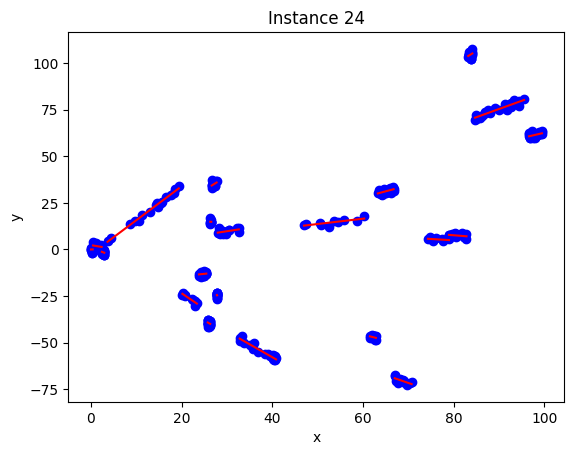

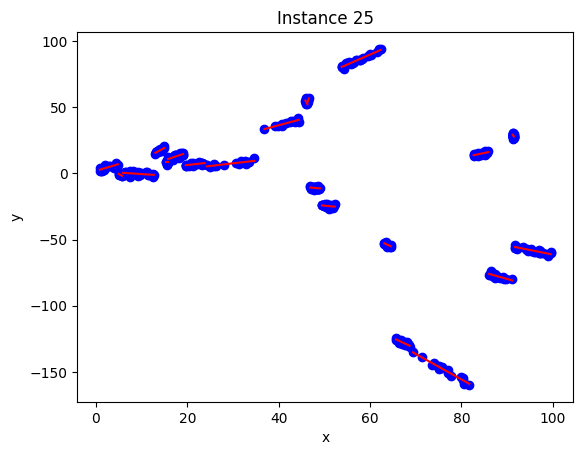

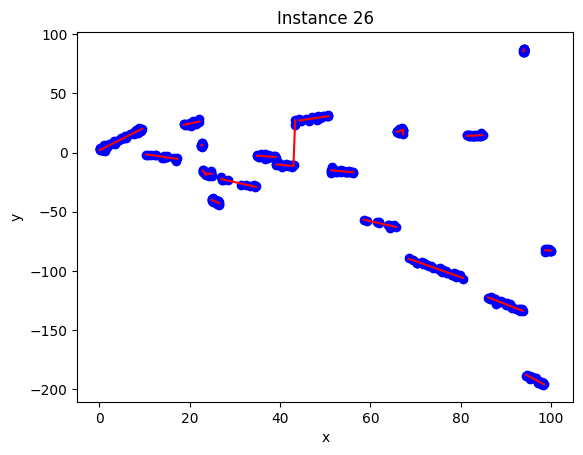

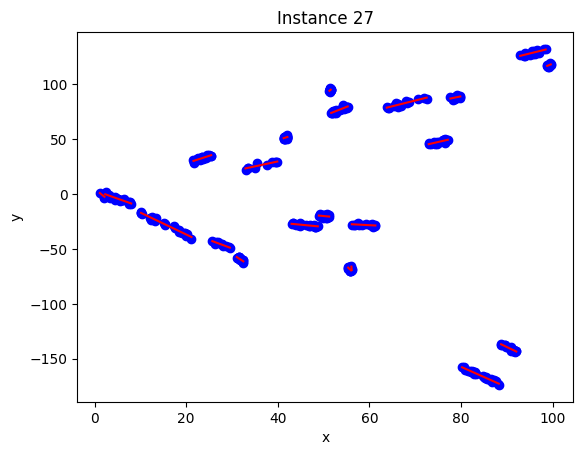

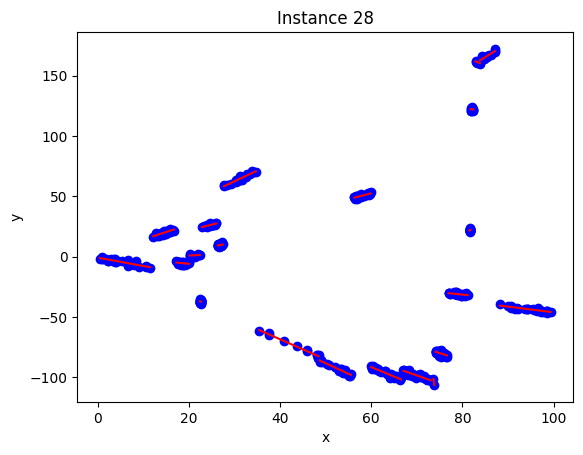

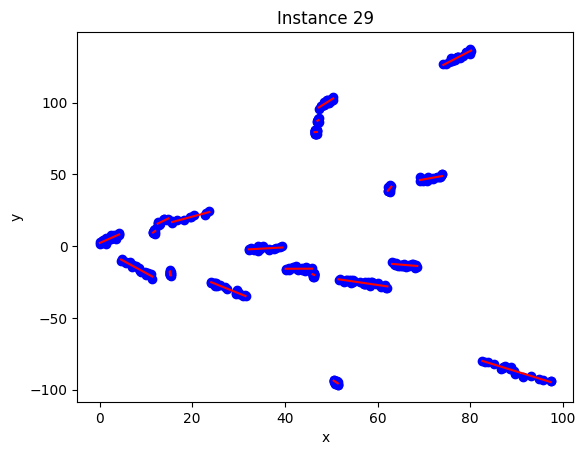

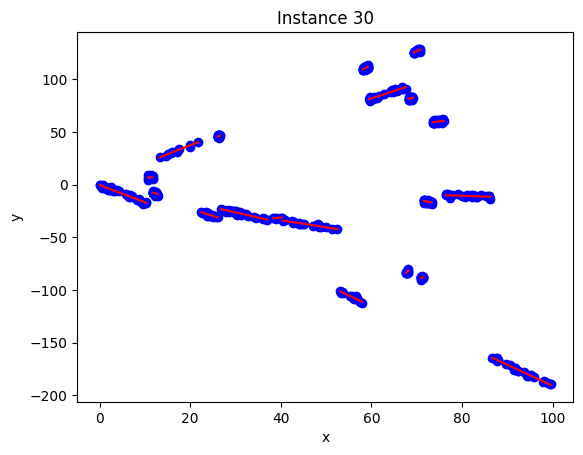

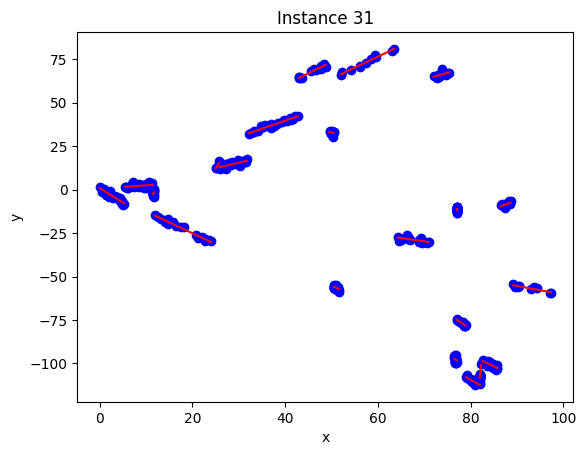

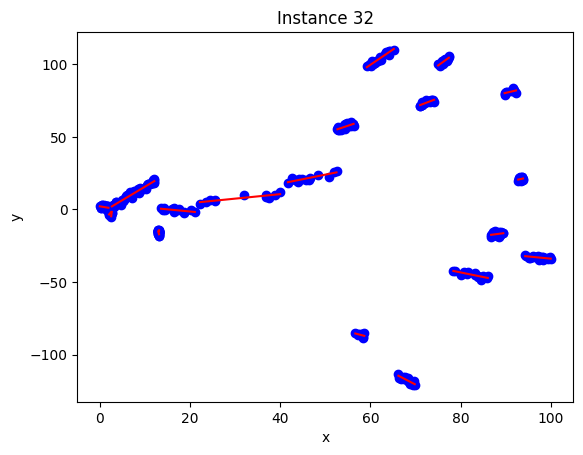

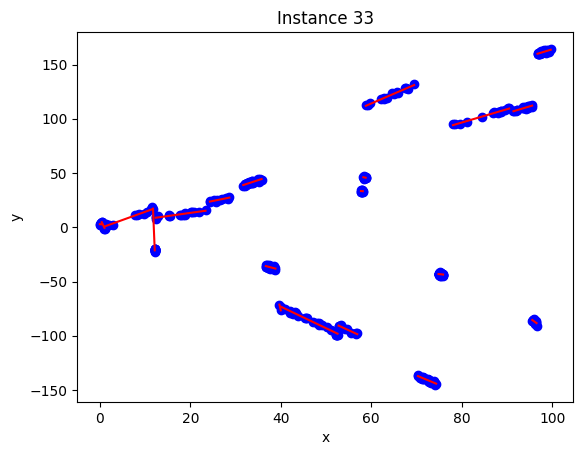

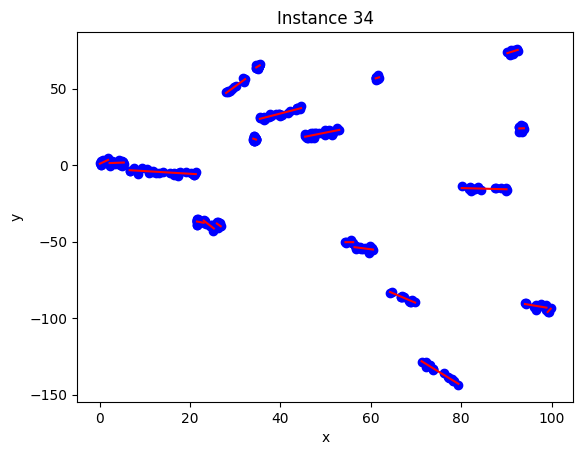

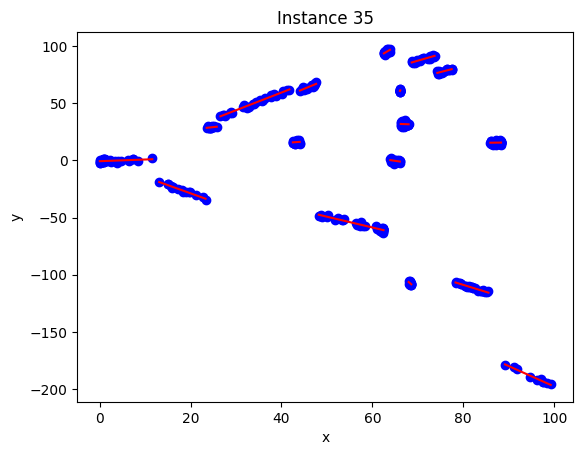

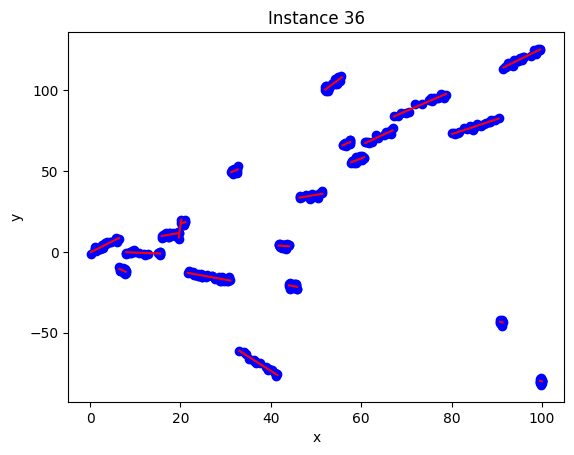

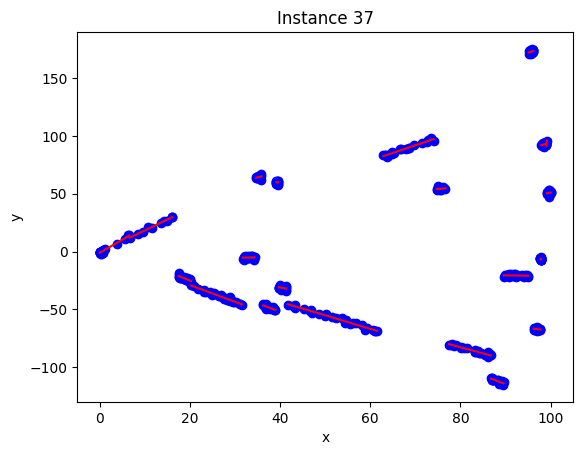

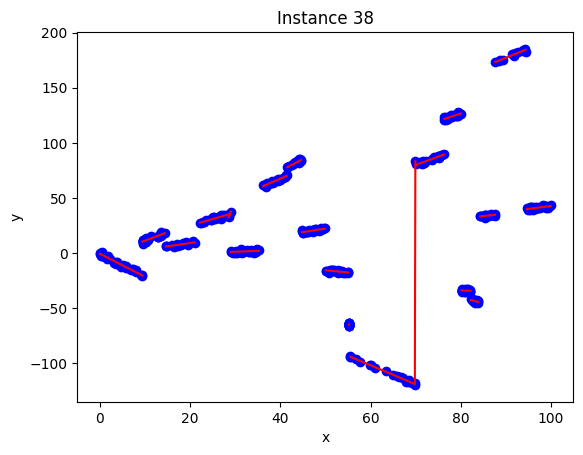

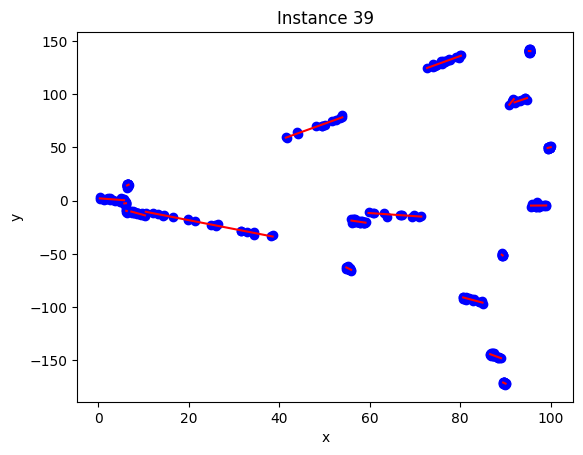

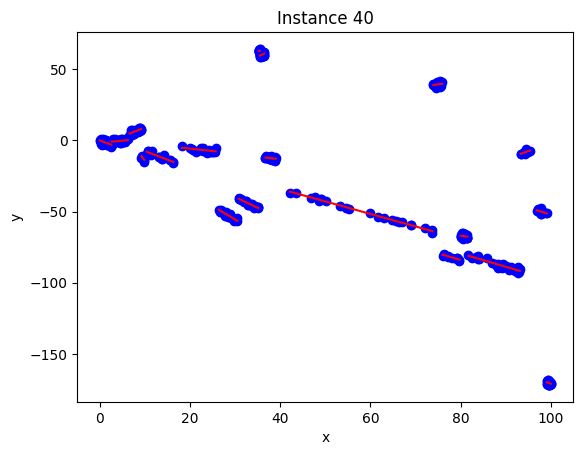

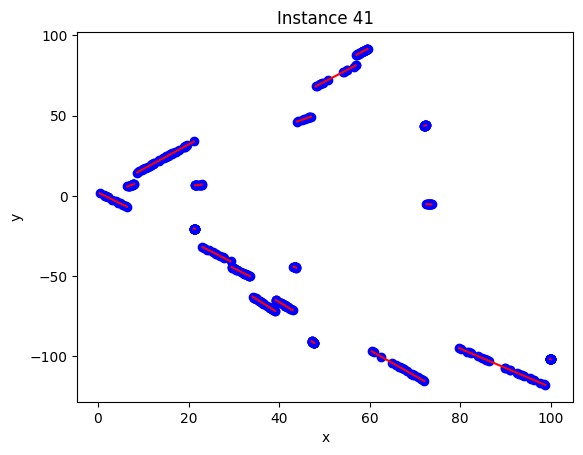

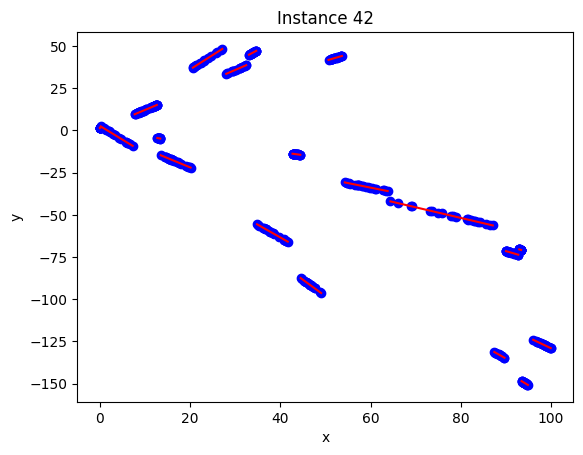

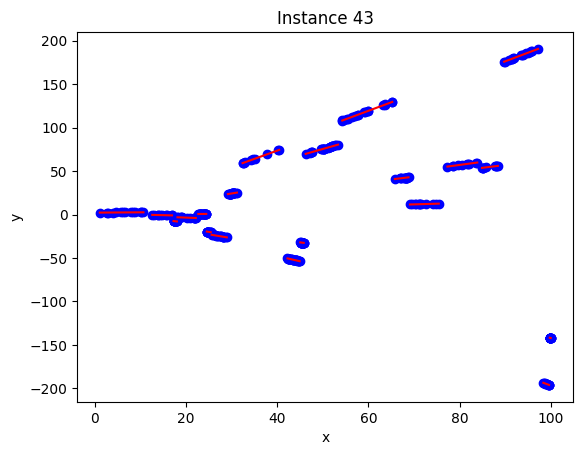

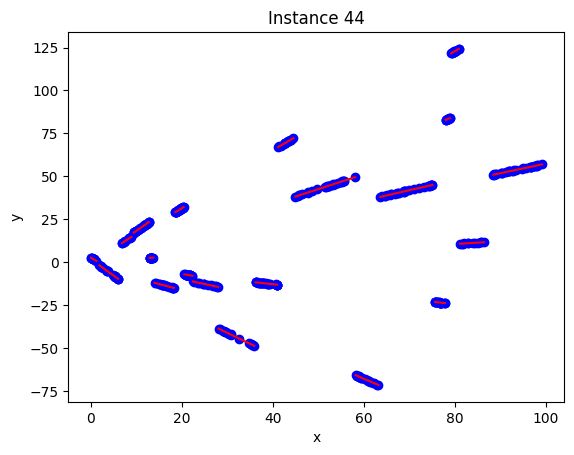

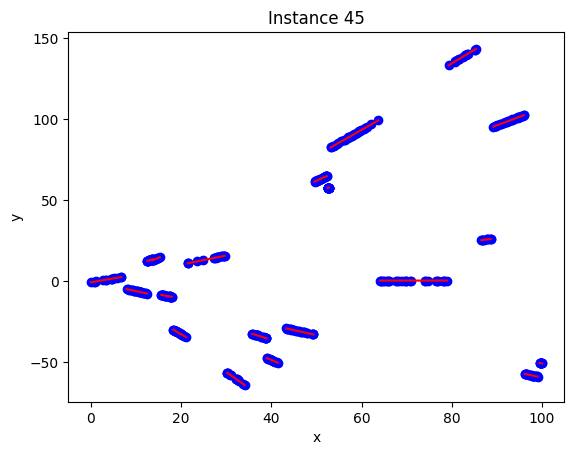

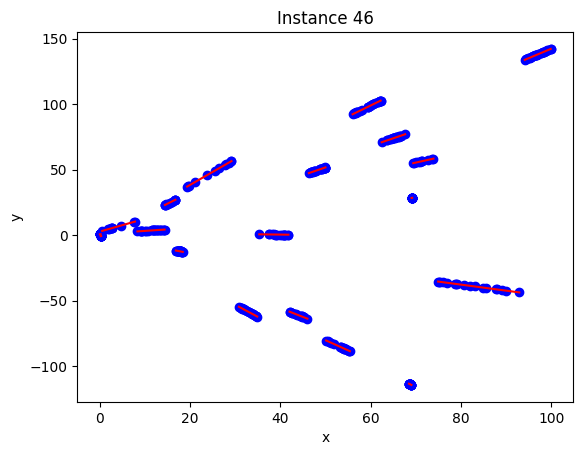

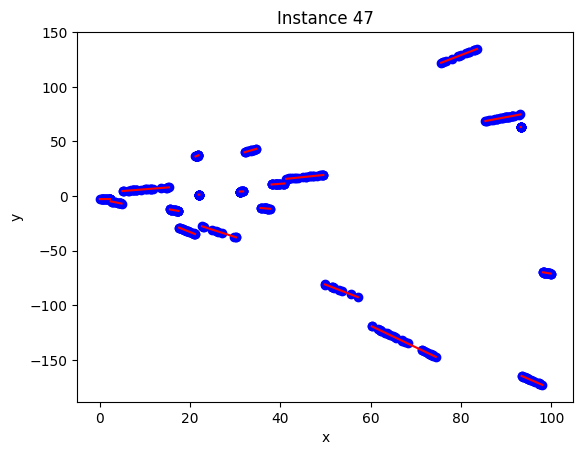

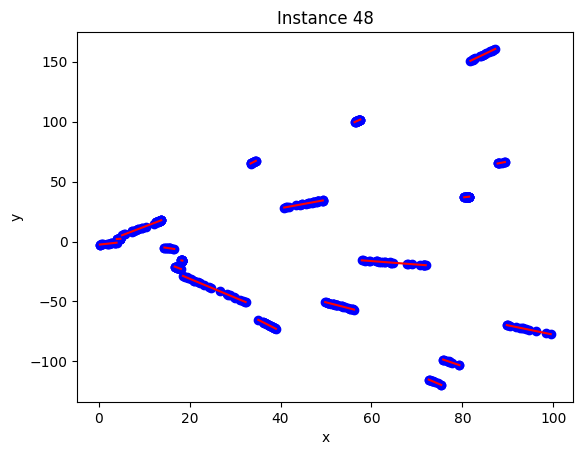

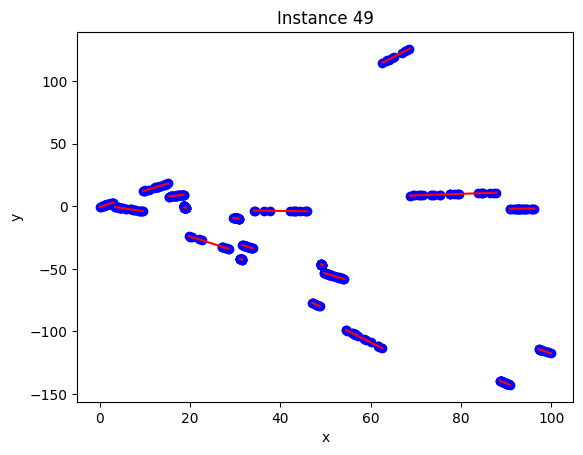

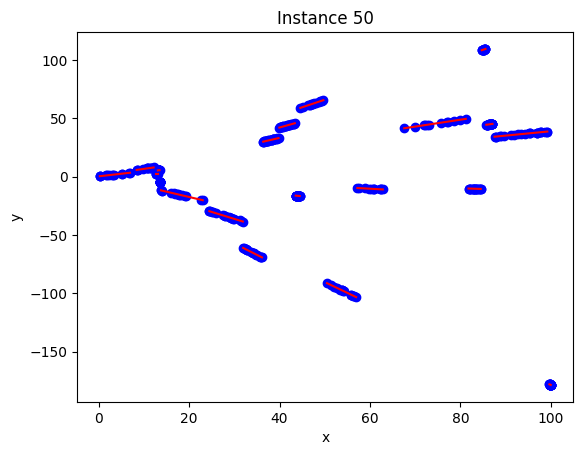

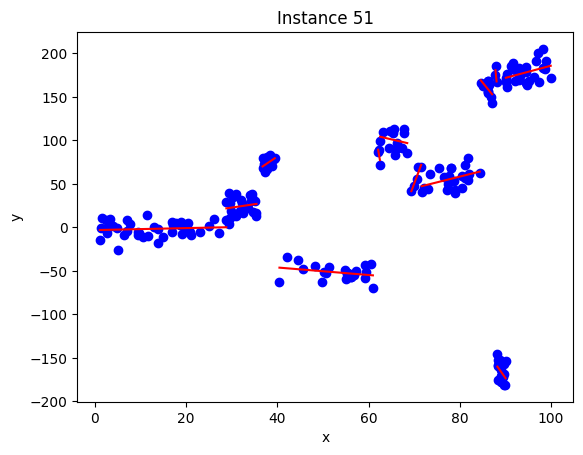

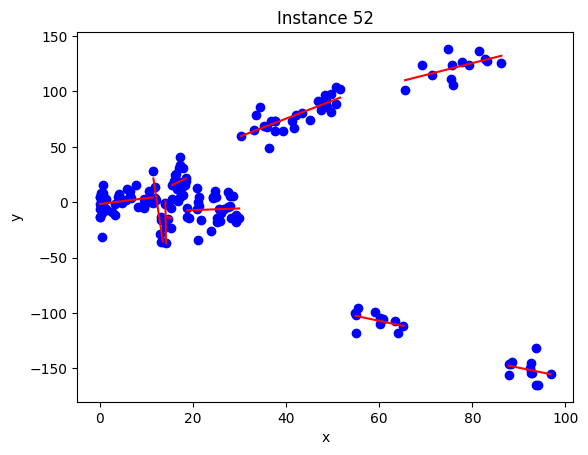

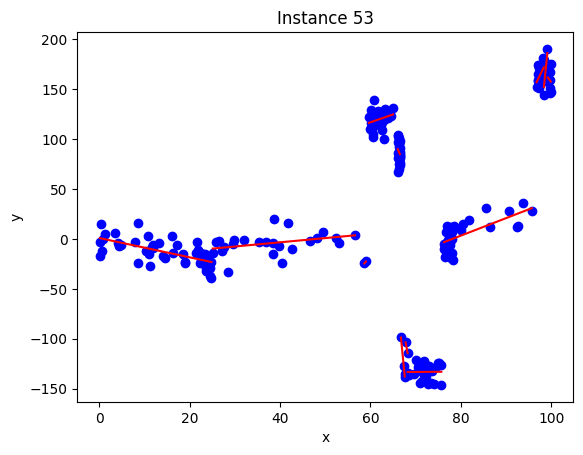

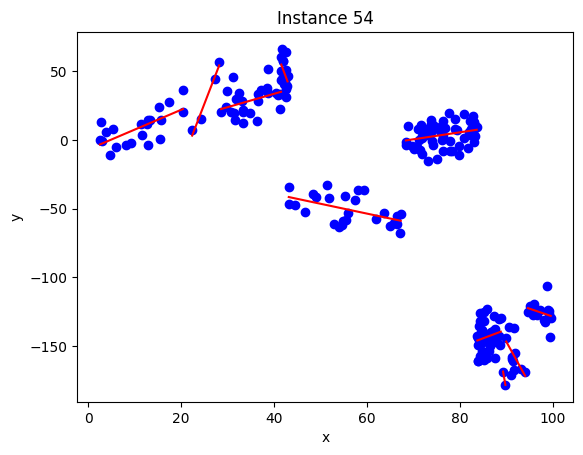

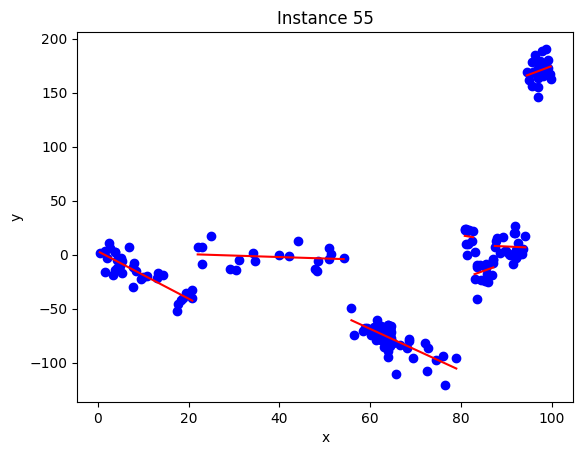

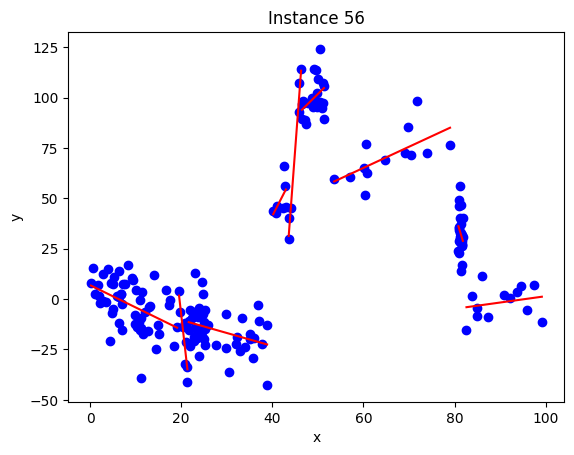

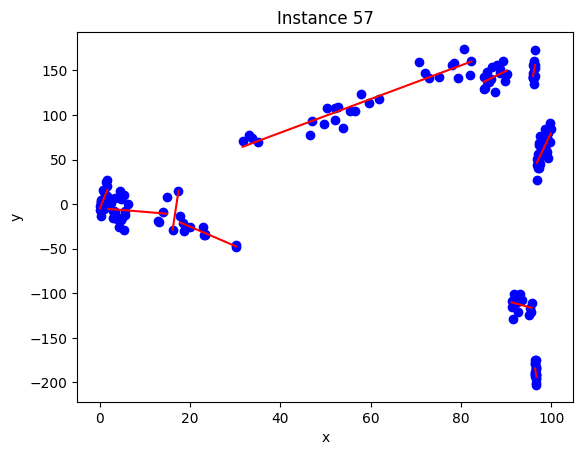

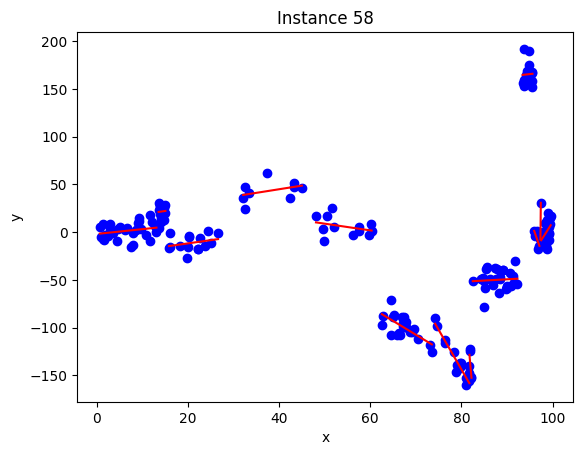

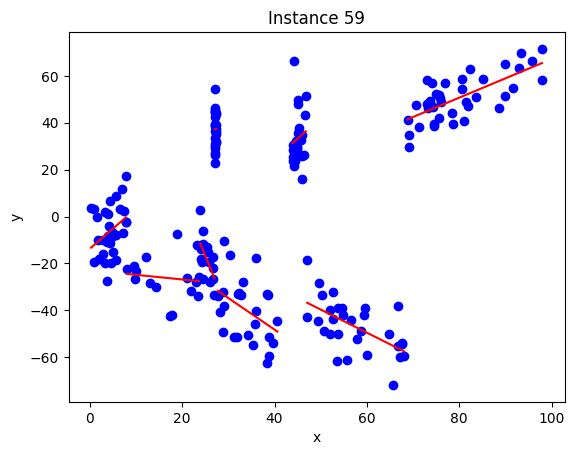

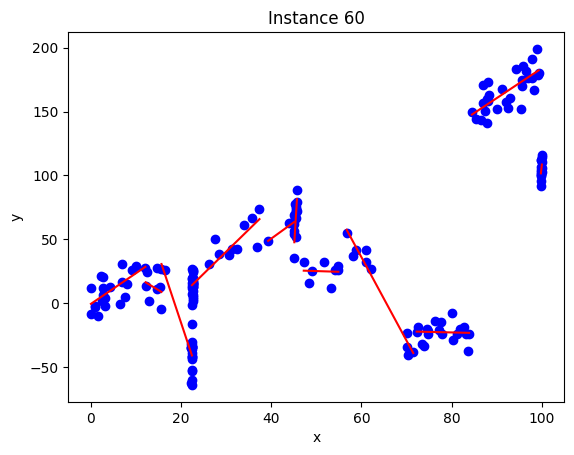

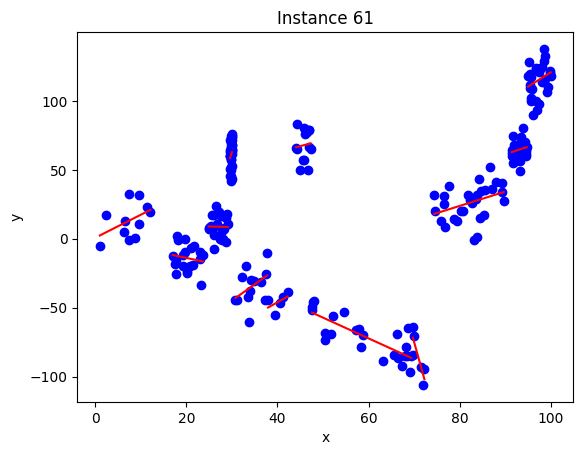

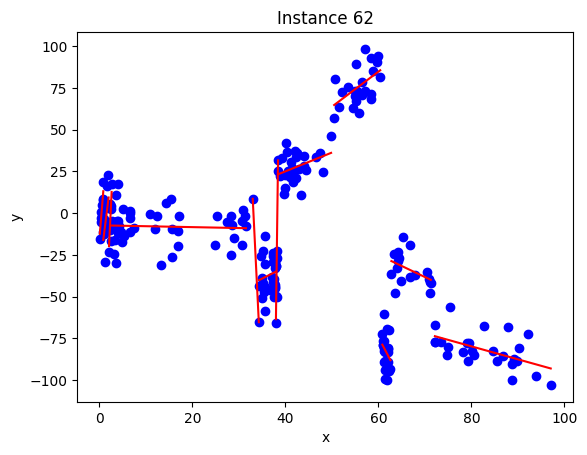

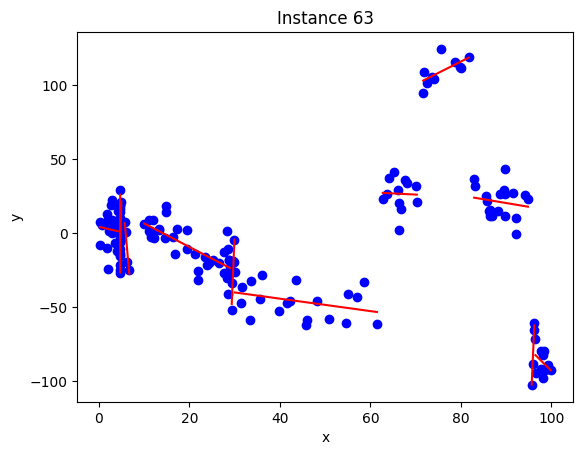

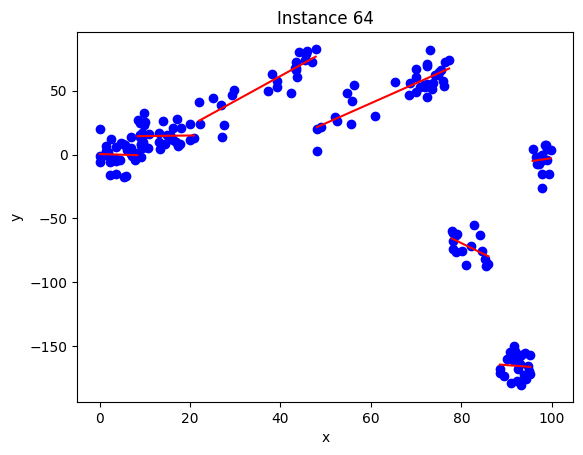

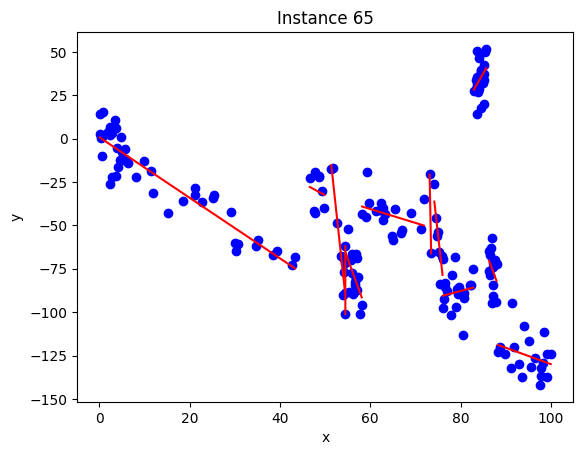

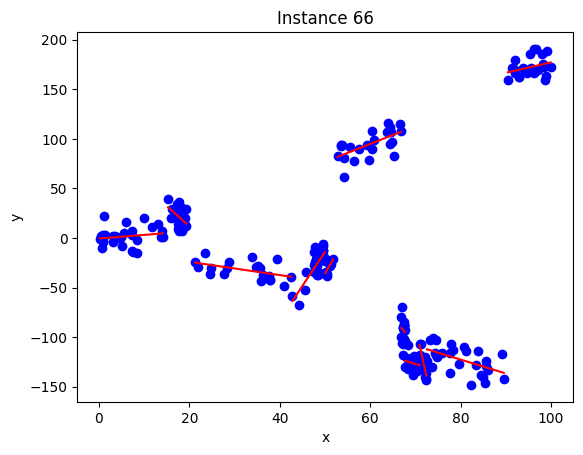

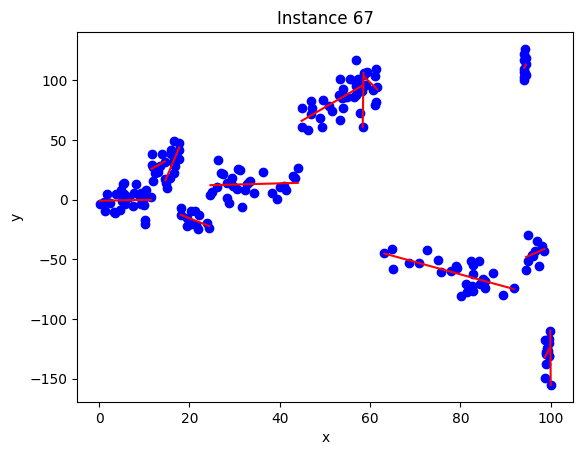

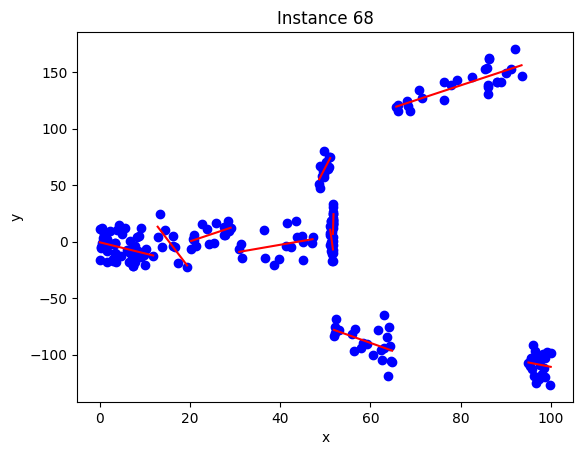

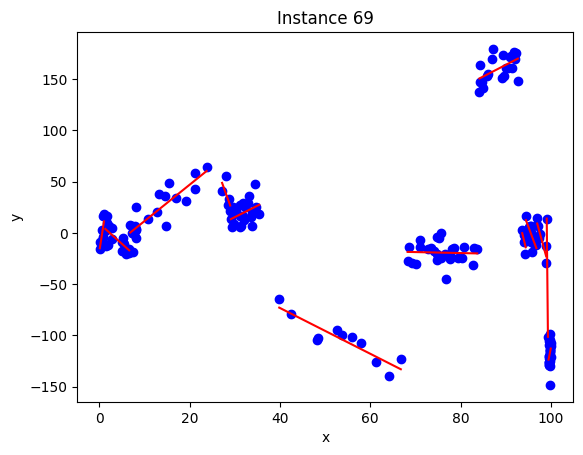

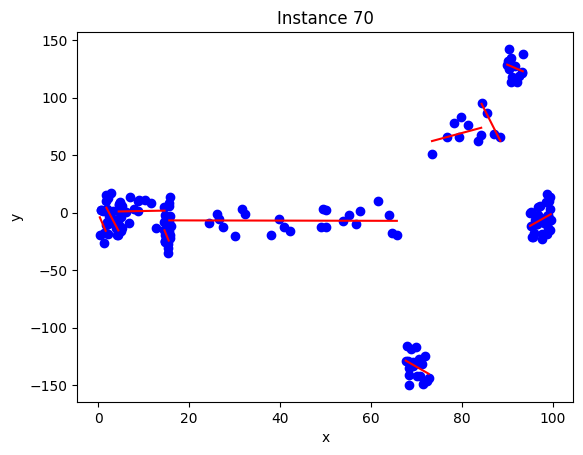

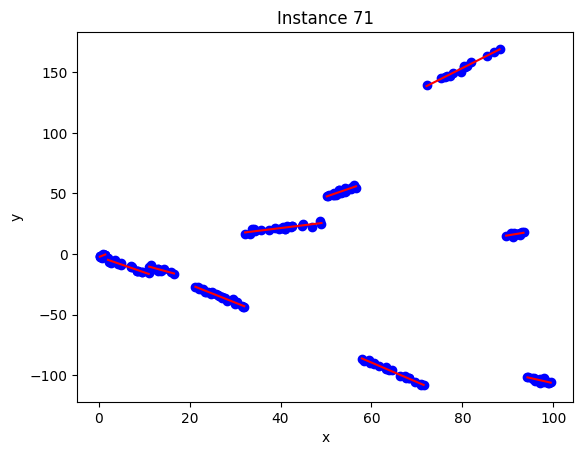

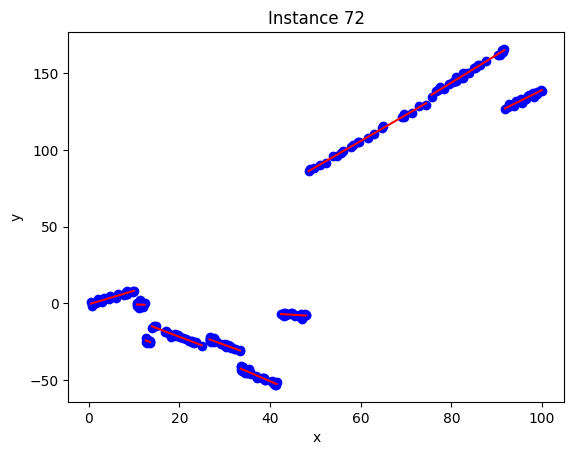

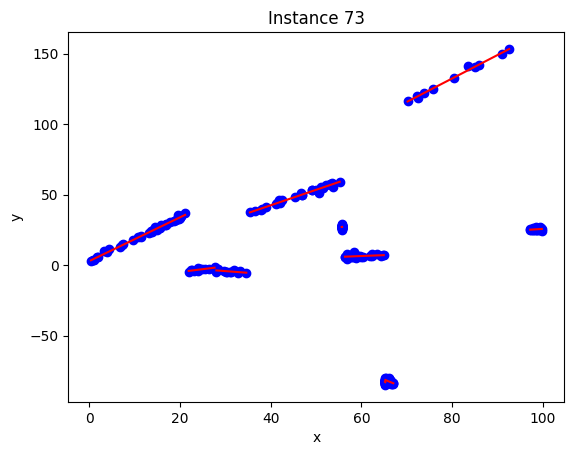

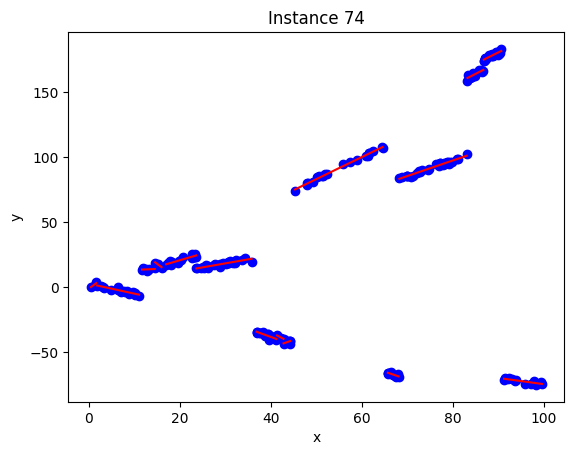

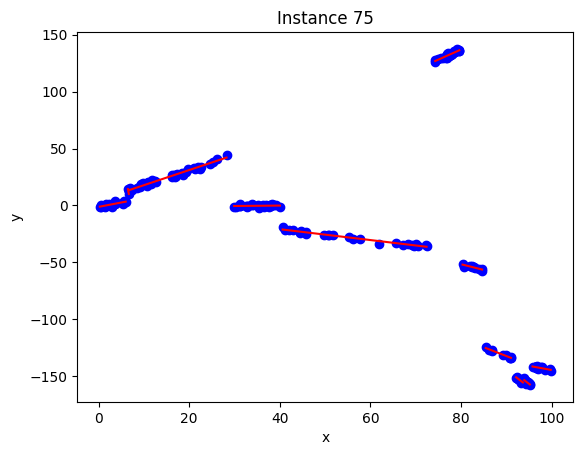

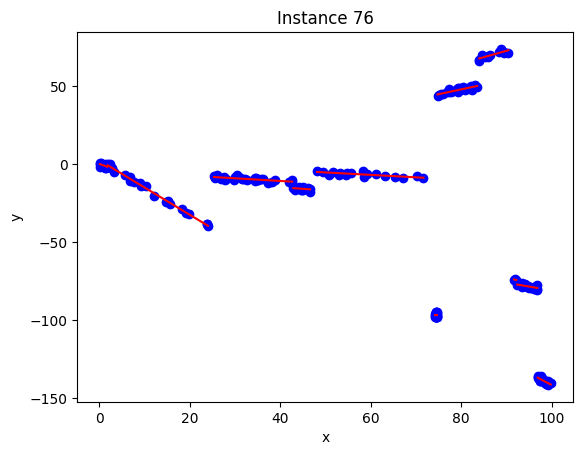

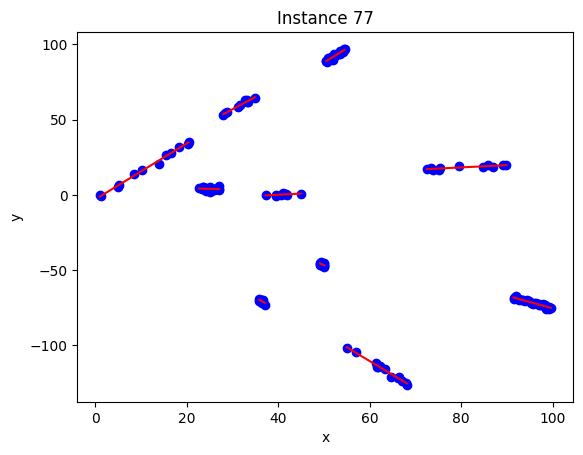

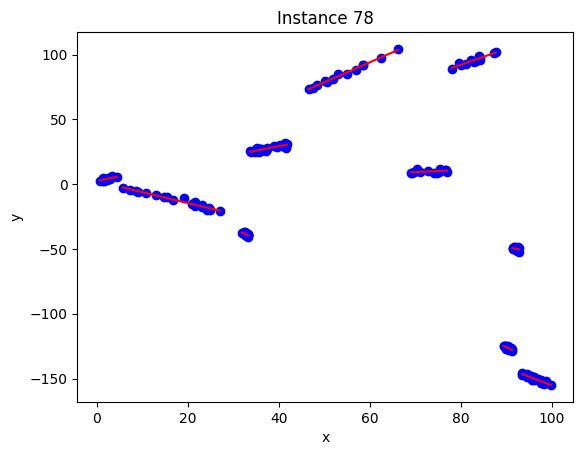

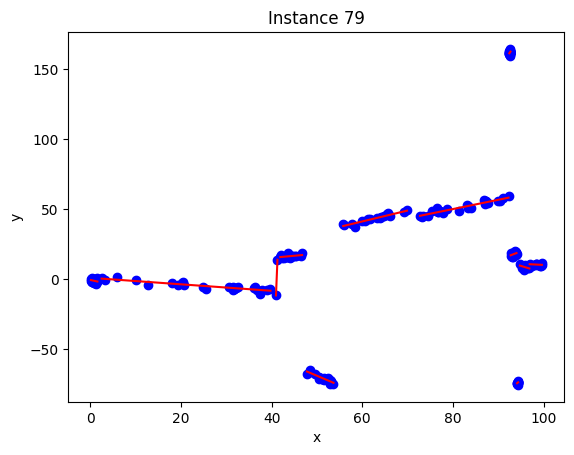

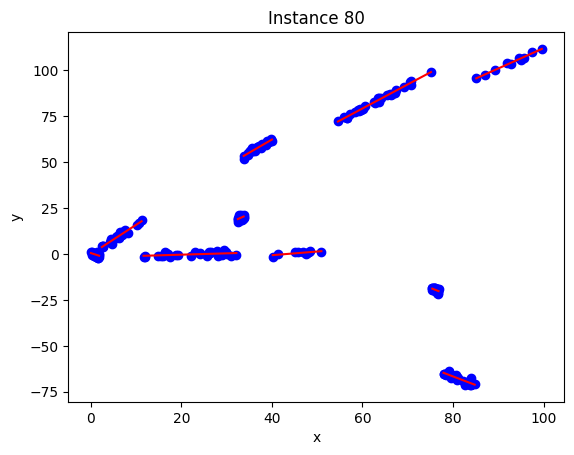

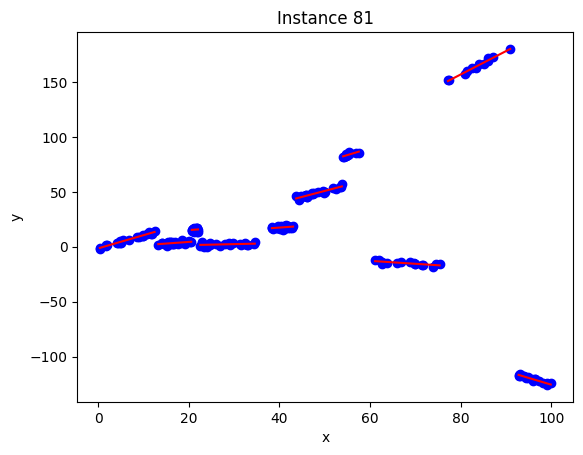

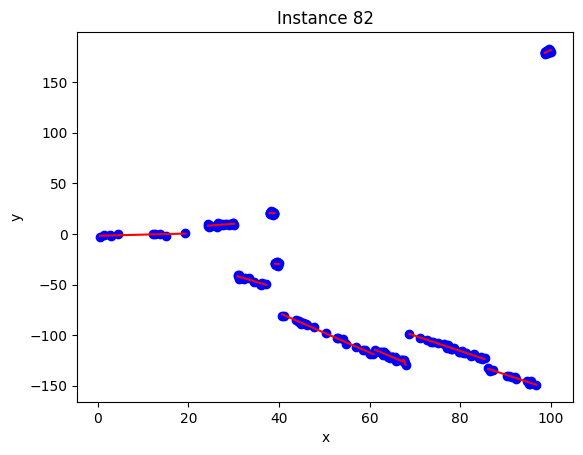

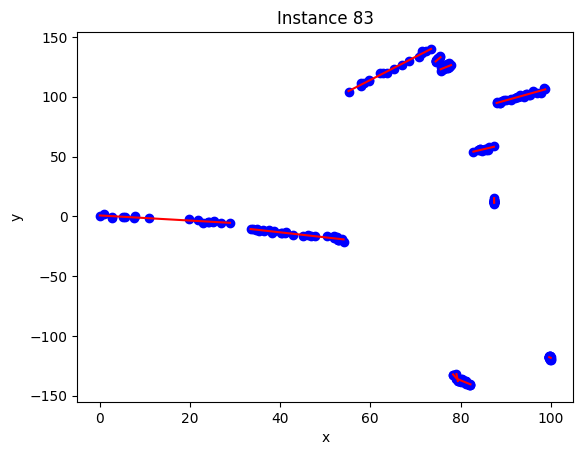

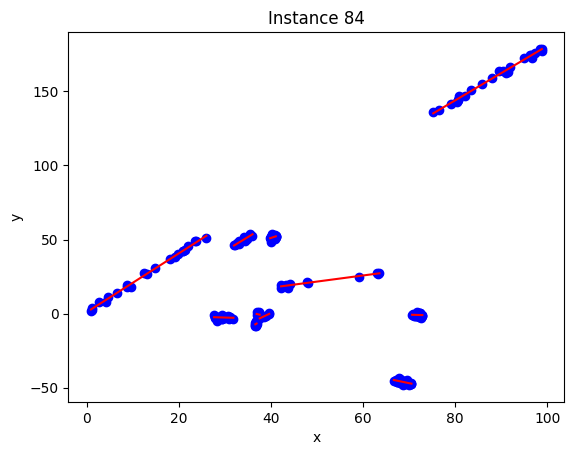

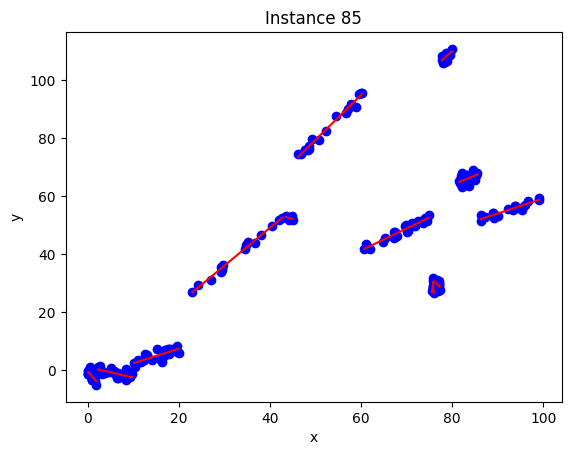

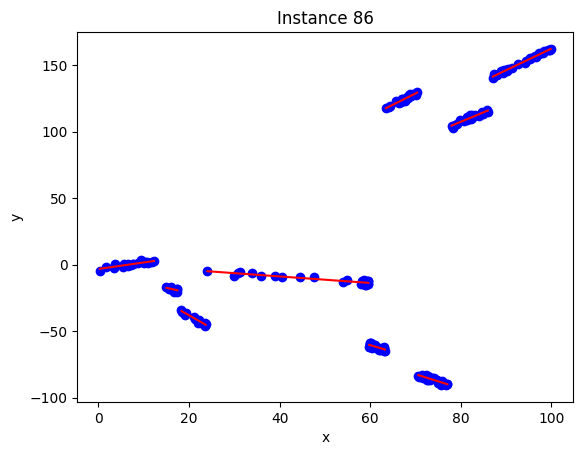

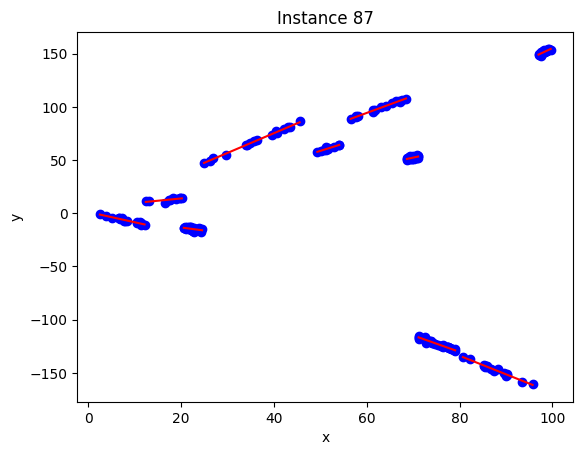

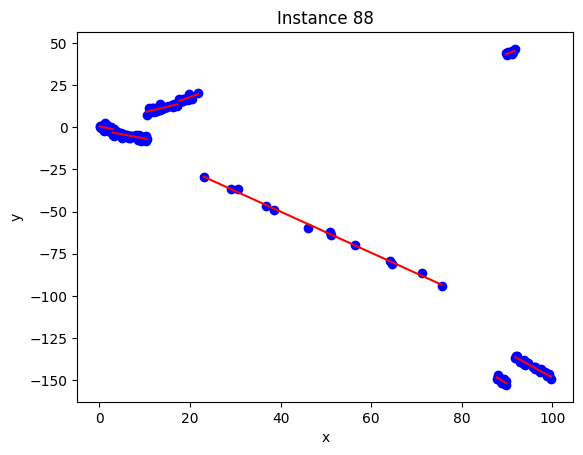

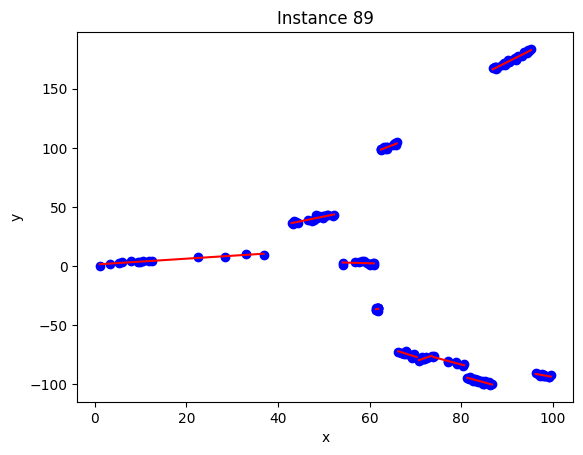

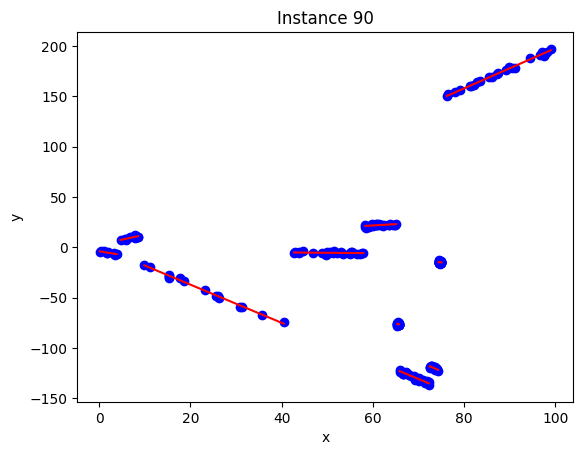

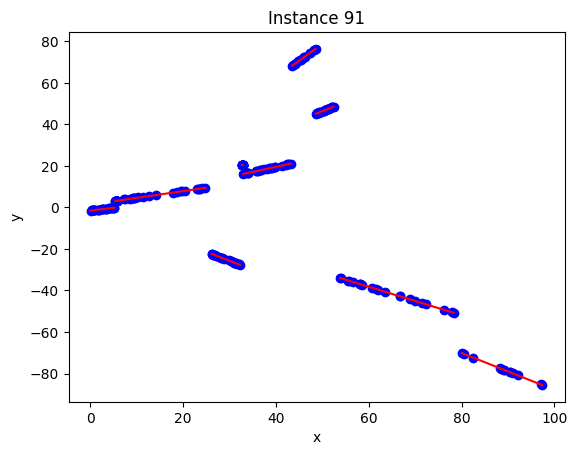

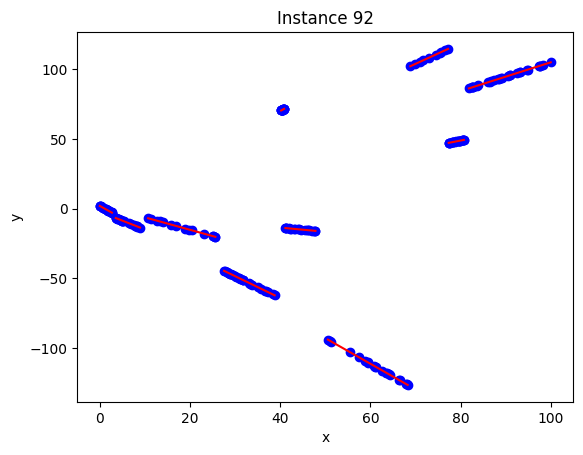

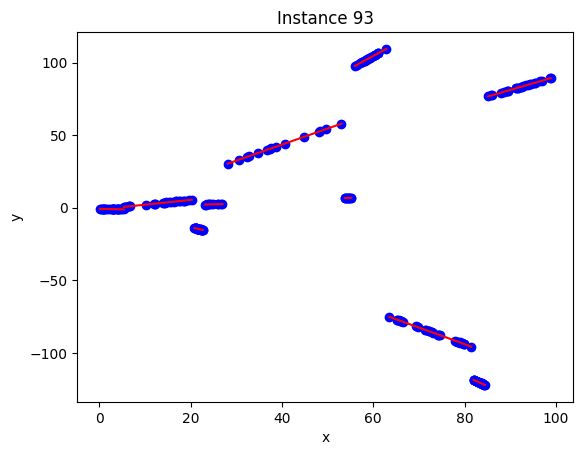

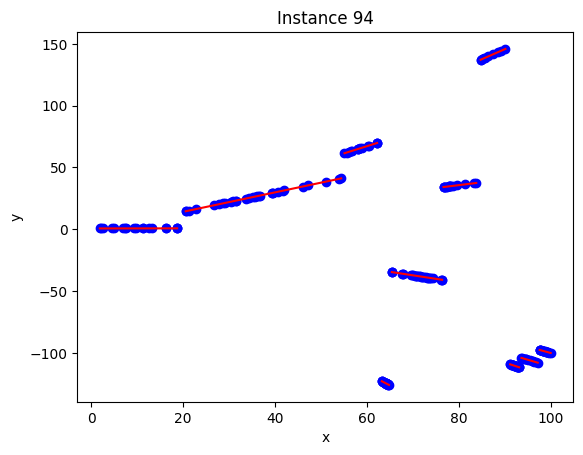

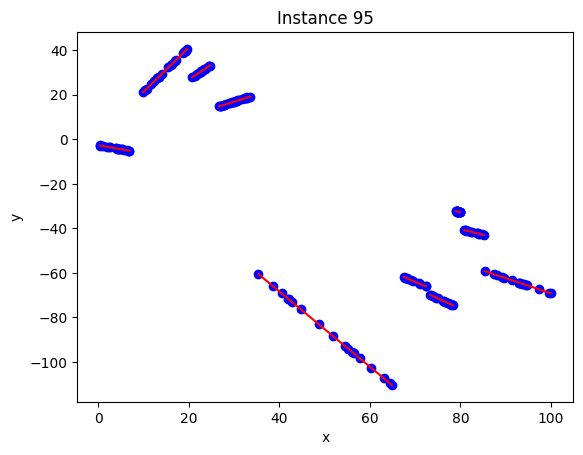

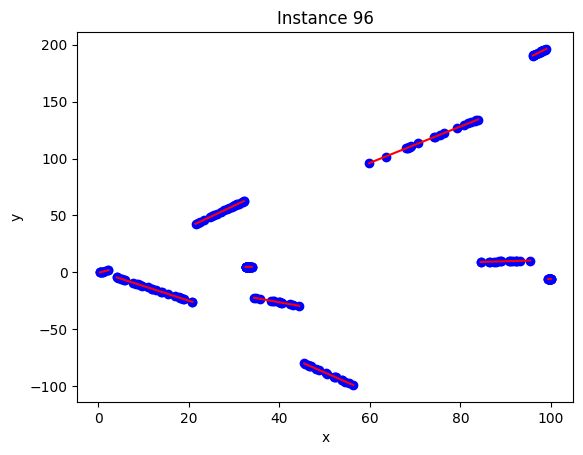

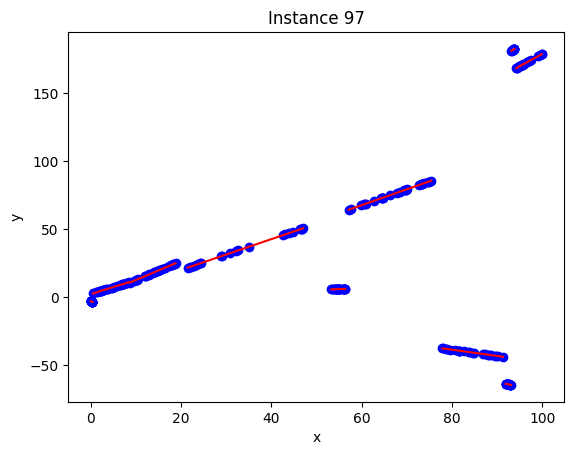

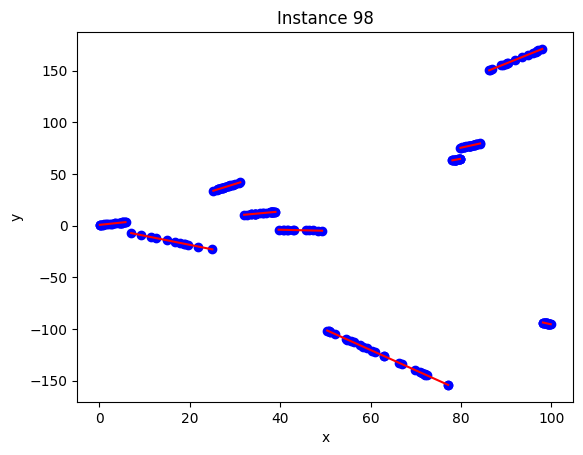

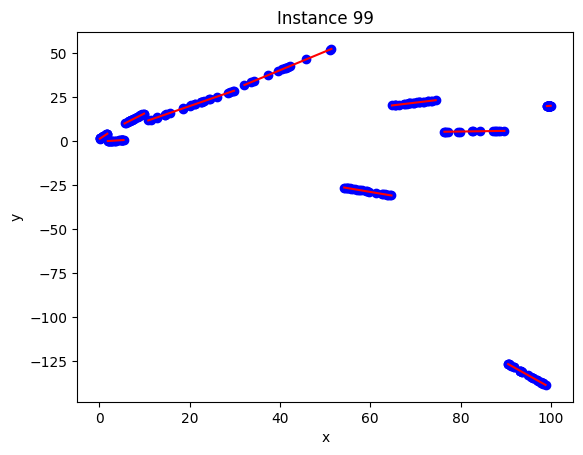

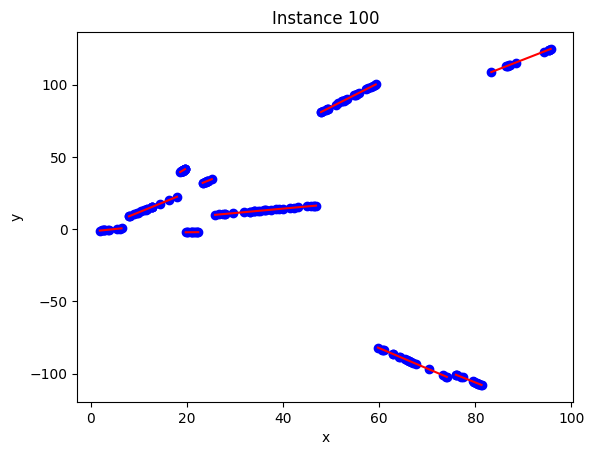

In [17]:
print("Solution dictionary printed below and outputted to file named 'Solution' in current working directory.")
print(multiLineFitting(data))